In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from tqdm import tqdm

In [2]:
class SpecificSoftmaxMSE():

    def __init__(self, neuron, y_true=0, dim=1):
        """
        Args:
        Name     Type    Desc
        neuron:  int     The output neuron to minimize
        y_true   float   The desired activation
        dim      int     The softmax axis. Default is one for tensor with shape (n_batches, n_classes)
        """
        super().__init__()
        self.neuron = neuron
        self.y_true = y_true
        self.logits = nn.Softmax(dim=dim)

    """
    Compute the MSE after computing the softmax of input.
    Forward is implemented in the __call__ method of super
    """
    def forward(self, y_pred):
        """
        Args
        y_pred  torch.tensor The output of the networ. Preferable shape (n_batch, n_classes)
        """
        if len(y_pred.shape) == 1:
            y_pred = y_pred.reshape(1, -1)
        return 0.5*(self.y_true - self.logits(y_pred)[:, self.neuron])**2
    
    def __call__(self, x):
        return self.forward(x)

In [59]:
class ClassicZSCG(object):
    """
    Args:
    Name            Type                Description
    model:          (nn.Module)         The model to use to get the output
    loss:           (nn.Module)         The loss to minimize
    device:
    """
    def __init__(self, model, loss, device=torch.device('cuda')):
        self.device = device
        self.loss = loss
        self.model = model.to(self.device)
        self.model.eval()


    def run(self, x, v, mk, ak , epsilon,
            C = (0, 1), max_steps=100,
            stop_criterion=1e-3, verbose=0,
            additional_out=False, tqdm_disabled=False):
        """
        Args:
        Name            Type                Description
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        v:              (float)             The gaussian smoothing
        mk:             (list)              Number of normal vector to generate at every step
        ak              (list)              Pseudo learning rate/momentum  every step
        epsilon:        (float)             The upper bound of the infinity norm
        C:              (tuple)             The boundaires of the pixel. Default is (0, 1)
        max_steps:      (int)               The maximum number of steps. Default is 100
        stop_criterion  (float)             The minimum loss function. Default is 1e-3
        verbose:        (int)               Display information or not. Default is 0
        additional_out  (bool)              Return also all the x. Default is False
        tqdm_disable    (bool)              Disable the tqdm bar. Default is False
        """
        x = x.to(self.device)

        # 1. Init class attributes
        self.create_boundaries(x, epsilon, C) # Set x_original min and max
        self.dim = x.shape
        self.total_dim = torch.prod(torch.tensor(x.shape))
        self.epsilon = epsilon

        # 2. Init list of results
        losses, outs = [], [] # List of losses and outputs

        # 3. Main optimization cycle
        for ep in tqdm(range(max_steps), disable=tqdm_disabled):
            if verbose:
                print("---------------")
                print("Step number: {}".format(ep))
            # 3.1 Call the step
            x, gk = self.step(x, v, ak[ep], mk[ep], verbose)
            x = x.reshape(self.dim[0], self.dim[1], self.dim[2]).detach()
            # 3.2 Compute loss
            out = self.model(x.view(1, self.dim[0], self.dim[1], self.dim[2]))
            loss = self.loss(out)
            # 3.3 Save results
            losses.append(loss.detach().cpu().item())
            outs.append(out.detach().cpu()[0, self.loss.neuron].item())
            # 3.4 Display current info
            if verbose:
                print("Loss:        {}".format(losses[-1]))
                print("Output:      {}".format(outs[-1]))
            # 3.5 Check Stopping criterion
            if loss < stop_criterion:
                break


        return  x, losses, outs


    def step(self, x, v, ak, mk, verbose=0):
        # Compute the approximated gradient
        g = self.compute_Gk(x, v, mk, verbose)
        # Call the inexact conditional gradient
        x_g = self.compute_CG(x, g, verbose).reshape(x.shape[0], x.shape[1], x.shape[2])
        x_new = (1-ak)*x + ak*x_g

        if verbose > 1:
            print("\nINSIDE STEP")
            print("Gradient has shape: {}".format(g.shape))
            print("Gradient is:\n{}".format(g))
            print("x_new has shape: {}".format(x_new.shape))
            print("x_new is:\n{}".format(x_new))

        return x_new.detach(), g.detach()

    """
    Compute the Gv(x(k-1), chi(k-1), u(k)) in order to compute an approximation of the gradient of f(x(k-1), chi(k-1))
    """
    def compute_Gk(self, x, v, mk, verbose=0):
        """
        Args:
        Name            Type                Description
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        v:              (float)             The gaussian smoothing
        verbose:        (bool)              Display information or not. Default is 0
        """
        # 1. Create x(k-1) + v*u(k-1)
        uk     = torch.empty(mk, self.total_dim).normal_(mean=0, std=1).to(self.device) # Dim (mk, channel*width*height)
        img_u  = uk.reshape(mk, self.dim[0], self.dim[1], self.dim[2])                  # Dim (mk, channel, width, height)
        img_x  = x.expand(mk, self.dim[0], self.dim[1], self.dim[2])                    # Dim (mk, channel, width, height)
        m_x    = (img_x + v*img_u)                                                      # Dim (mk, channel, width, height)

        if verbose > 1:
            print('\nINSIDE GRADIENT')
            print('The Gaussian vector uk has shape:{}'.format(uk.shape))
            print('The input x has shape:\t\t{}'.format(x.shape))
            print('The input x + vu has shape:\t{}'.format(m_x.shape))

        # 2. Get objective functions
        standard_loss = self.loss(self.model(x.view(1, x.shape[0], x.shape[1], x.shape[2])))                                        # Dim (1)
        gaussian_loss = self.loss(self.model(m_x))                                      # Dim (mk)

        # 3. Compute Gv(x(k-1), chi(k-1), u(k))
        fv = ((gaussian_loss - standard_loss.expand(uk.shape[0]))/v).view(-1, 1)        # Dim (mk, 1)
        G = fv * uk                                                                     # Dim (mk, channel*width*height)

        return torch.mean(G, axis=0).detach()


    def compute_CG(self, x, g, verbose):
        """
        Args:
        Name            Type                Description
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        g:              (torch.tensor)      The approximated gradient. Should be a 1D tensor
        """
        # 1. Init variables
        x = x.view(-1) # dim = (n_channel * width * height)
        u = torch.rand(self.total_dim).to(self.device)*(self.max.view(-1) - self.min.view(-1)) + self.min.view(-1)

        # 2. Main cycle
        x_new = self.check_boundaries(self.x_original.view(-1) - self.epsilon*torch.sign(g))

        if verbose > 1:
            print('\nINSIDE CG')
            print('Epsilon * Sign(g) is {}'.format(self.epsilon*torch.sign(g)))
            print('Unchecked new x is: {}'.format(self.x_original.view(-1) - self.epsilon*torch.sign(g)))
            print('The CG gradient is:\n{}'.format(g))
            print('The new x is:\n {}'.format(x_new))

        return x_new.detach()


    def create_boundaries(self, x, epsilon, C):
        """
        Args:
        Name            Type                Description
        x:              (torch.tensor)      The original image. Should be a 3D tensor (img)
        epsilon:        (float)             The maximum value of ininity norm.
        """
        self.x_original = x.clone().to(self.device)           # dim = (n_channel, width, height)
        self.max = (self.x_original+epsilon).to(self.device)  # dim = (n_channel, width, height)
        self.min = (self.x_original-epsilon).to(self.device)  # dim = (n_channel, width, height)
        self.C = C
        self.max[self.max > C[1]] = C[1]
        self.min[self.min < C[0]] = C[0]

    def check_boundaries(self, x):
        x[x > self.C[1]] = self.C[1]
        x[x < self.C[0]] = self.C[0]
        return x

In [44]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 3, (2, 2), stride=2, padding=1)
        self.linear = nn.Linear(3, 3)


    def forward(self, x):
        x = nn.ReLU()(self.conv(x))
        return nn.Sigmoid()(self.linear(x.view(x.shape[0], -1)))

In [45]:
net = Net()
original_x = torch.rand(1, 1, 1).float() + 25
original_out = net(original_x.view(1, 1, 1, 1))[0].data
print('X is {:.5f}'.format(float(original_x)))
print('Out is {}'.format(original_out))

X is 25.58847
Out is tensor([0.8694, 0.1029, 0.0351])


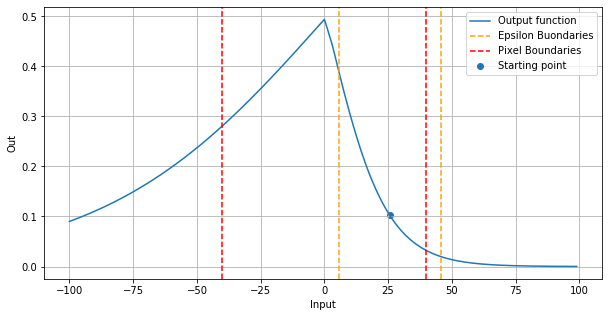

In [46]:
n = 1

xs, outs1 = [], []
for x in range(-100, 100):
    xs.append(x)
    outs1.append(net(torch.tensor([x]).view(1, 1, 1, 1).float())[0, n])

plt.figure(figsize = (10, 5))
plt.plot(xs, outs1, label = 'Output function')
plt.axvline(original_x + 20, linestyle='--', color='orange', label = 'Epsilon Buondaries')
plt.axvline(original_x -20, linestyle='--', color='orange')
plt.axvline(-40, linestyle='--', color='red', label = 'Pixel Boundaries')
plt.axvline(40, linestyle='--', color='red')
plt.scatter(original_x, original_out[n], label='Starting point')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Out')
plt.grid()
plt.show()

In [47]:
N = 5
d = torch.prod(torch.tensor(original_x.shape))

params = {'x':              original_x,
          'v':              (1/(2*N*(d+3)**3))**0.5,
          'mk':             [6*(d+5)*N]*N,
          'ak':             [0.5]*N,
          'C':              (-40, 40), 
          'epsilon':        20,
          'max_steps':      N,
          'stop_criterion': 1e-1,
          'verbose':        2
         }

In [48]:
device = torch.device('cuda')
loss_fn = SpecificSoftmaxMSE(neuron=n, y_true=0)
optim = ClassicZSCG(model=net, loss=loss_fn)
x_new, losses, outs = optim.run(**params)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

---------------
Step number: 0

INSIDE GRADIENT
The Gaussian vector uk has shape:torch.Size([180, 1])
The input x has shape:		torch.Size([1, 1, 1])
The input x + vu has shape:	torch.Size([180, 1, 1, 1])

INSIDE CG
Epsilon * Sign(g) is tensor([-20.], device='cuda:0')
The CG gradient is:
tensor([-0.0005], device='cuda:0')
The new x is:
 tensor([40.], device='cuda:0')

INSIDE STEP
Gradient has shape: torch.Size([1])
Gradient is:
tensor([-0.0005], device='cuda:0')
x_new has shape: torch.Size([1, 1, 1])
x_new is:
tensor([[[32.7942]]], device='cuda:0')
Loss:        0.026959720999002457
Output:      0.05807171016931534


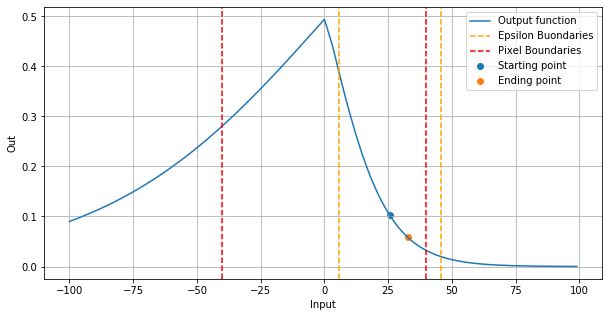

In [49]:
net = net.cpu()
out_new =  net(torch.tensor([x_new]).view(1, 1, 1, 1).float())[0, n]

plt.figure(figsize = (10, 5))
plt.plot(xs, outs1, label = 'Output function')
plt.axvline(original_x + 20, linestyle='--', color='orange', label = 'Epsilon Buondaries')
plt.axvline(original_x -20, linestyle='--', color='orange')
plt.axvline(-40, linestyle='--', color='red', label = 'Pixel Boundaries')
plt.axvline(40, linestyle='--', color='red')
plt.scatter(original_x, original_out[n], label='Starting point')
plt.scatter(x_new.cpu().detach(), out_new.cpu().detach(), label='Ending point')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Out')
plt.grid()

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

0.003952847075210474
---------------
Step number: 0

INSIDE GRADIENT
The Gaussian vector uk has shape:torch.Size([18000, 1])
The input x has shape:		torch.Size([1, 1, 1])
The input x + vu has shape:	torch.Size([18000, 1, 1, 1])

INSIDE CG
Epsilon * Sign(g) is tensor([-20.], device='cuda:0')
Unchecked new x is: tensor([45.5885], device='cuda:0')
The CG gradient is:
tensor([-0.0003], device='cuda:0')
The new x is:
 tensor([40.], device='cuda:0')

INSIDE STEP
Gradient has shape: torch.Size([1])
Gradient is:
tensor([-0.0003], device='cuda:0')
x_new has shape: torch.Size([1, 1, 1])
x_new is:
tensor([[[40.]]], device='cuda:0')
Loss:        0.025491604581475258
Output:      0.1840783655643463


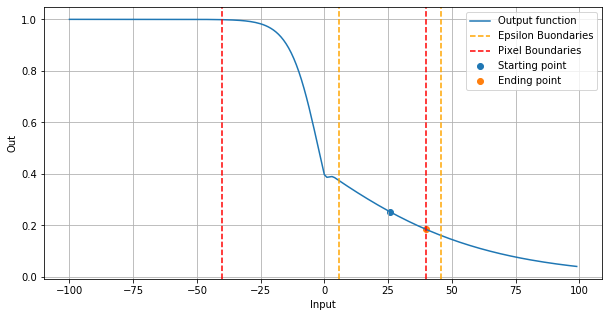

In [80]:
def run_example(epoch, params, bias = 20):
    net = Net()
    original_x = torch.rand(1, 1, 1).float() + 25
    original_out = net(original_x.view(1, 1, 1, 1))[0].data
    
    n = torch.argmin(original_out)
    outs1 = []
    xs = []
    for x in range(-100, 100):
        xs.append(x)
        outs1.append(net(torch.tensor([x]).view(1, 1, 1, 1).float())[0, n])
        
    device = torch.device('cuda')
    loss_fn = SpecificSoftmaxMSE(neuron=n, y_true=0)
    optim = ClassicZSCG(model=net, loss=loss_fn)
    x_new, losses, outs = optim.run(**params)
    
    net = net.cpu()
    out_new =  net(torch.tensor([x_new]).view(1, 1, 1, 1).float())[0, n]

    plt.figure(figsize = (10, 5))
    plt.plot(xs, outs1, label = 'Output function')
    plt.axvline(original_x + 20, linestyle='--', color='orange', label = 'Epsilon Buondaries')
    plt.axvline(original_x -20, linestyle='--', color='orange')
    plt.axvline(-40, linestyle='--', color='red', label = 'Pixel Boundaries')
    plt.axvline(40, linestyle='--', color='red')
    plt.scatter(original_x, original_out[n], label='Starting point')
    plt.scatter(x_new.cpu().detach(), out_new.cpu().detach(), label='Ending point')
    plt.legend()
    plt.xlabel('Input')
    plt.ylabel('Out')
    plt.grid()
    plt.show()
    
    return x_new, losses, outs


N = 500
d = float(torch.prod(torch.tensor(original_x.shape)))

params = {'x':              original_x,
          'v':              (1/(2*N*(d+3)**3))**0.5,
          'mk':             [int(6*(d+5)*N)]*N,
          'ak':             [1]*N,
          'C':              (-40, 40), 
          'epsilon':        20,
          'max_steps':      N,
          'stop_criterion': 1e-1,
          'verbose':        2
         }
print(params['v'])
X_new, l, o =  run_example(N, params)

In [72]:
(1/(2*500*(torch.tensor([1])+3)**3))**0.5,

(tensor([1]),)

In [24]:
optim.max

tensor([[[1.]]], device='cuda:0')